Read satellite data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
def read_satellite_data(veg_type, satellite):
    # Load vegetation class table
    veg_class = pd.read_csv('../data/veg_class_data/tables/veg_class.csv')
    df_satellite = pd.read_csv(f'../data/satellite_data/tables/phenology_climate/{satellite}.csv')
    df = pd.merge(df_satellite, veg_class, on=['latitude', 'longitude'], how='inner')
    # Filter for Forest classes
    if veg_type in (11, 12, 13, 14):
        df = df[df['veg_class'].isin([veg_type])]#.iloc[0:1000]
    else:
        df = df[df['veg_class'].isin([11, 12, 13, 14])]#.iloc[0:1000]

    # print(df)
    
    # Separate climate/phenology columns by type
    eos_cols = [col for col in df.columns if 'eos' in col]
    t_cols = [col for col in df.columns if 'annual_t' in col]
    p_cols = [col for col in df.columns if 'annual_p' in col]
    sos_cols = [col for col in df.columns if 'sos' in col]

    # === Period 1: 2001–2007 ===
    if satellite == "avhrr":
        years = [str(y) for y in range(1982, 2017)]
    elif satellite == "modis":
        years = [str(y) for y in range(2001, 2024)]
        # Build boolean masks
        mask_sos = (df[sos_cols] < 0).any(axis=1)      # True if any sos < 0
        mask_eos = (df[eos_cols] > 365).any(axis=1)    # True if any eos > 365
        # Keep only rows that do NOT violate the conditions
        df = df[~(mask_sos | mask_eos)].copy()
    else:
        years = [str(y) for y in range(2013, 2023)]
        mask_sos = (df[sos_cols] < 0).any(axis=1)      # True if any sos < 0
        mask_eos = (df[eos_cols] > 365).any(axis=1)    # True if any eos > 365
        # Keep only rows that do NOT violate the conditions
        df = df[~(mask_sos | mask_eos)].copy()
        
    cols = years
    df = df[[col for col in eos_cols + t_cols + p_cols + sos_cols if any(y in col for y in cols)] + ['latitude', 'longitude', 'veg_class']].copy()
    t_cols_df = [col for col in df.columns if 'annual_t' in col]
    df[t_cols_df] = df[t_cols_df] - 273.5  # Convert temperature
    df.columns = df.columns.str.replace(r'\D*(\d{4})$', lambda m: f"{m.group(0)[0:-4]}{m.group(1)}", regex=True)
    df['annual_t'] = df[[col for col in df.columns if 'annual_t' in col]].mean(axis=1)
    df['annual_p'] = df[[col for col in df.columns if 'annual_p' in col]].mean(axis=1)
    df['eos'] = df[[col for col in df.columns if 'eos' in col]].mean(axis=1)
    df['sos'] = df[[col for col in df.columns if 'sos' in col]].mean(axis=1)
    return df

In [2]:
## Plot prcp threshold

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

def plot_mean_eos_by_temp_precip(df, temp_col='annual_t', precip_col='annual_p', eos_col='eos'):
    df = df.copy()

    # Bin precipitation, restrict to 0.7 - 1.4 m
    df['precip_bin'] = np.floor(df[precip_col] * 10) / 10
    bins = sorted([b for b in df['precip_bin'].dropna().unique() if 0.6 <= b <= 1.3])

    n_cols = 4
    n_rows = int(np.ceil(len(bins) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 6), sharex=True, sharey=True)
    axes = axes.flatten()

    plot_idx = 0
    for bin_val in bins:
        sub_df = df[df['precip_bin'] == bin_val].copy()
        # if len(sub_df) < 10:
        #     continue

        # Remove EOS outliers
        # eos_low = sub_df[eos_col].quantile(0.01)
        # eos_high = sub_df[eos_col].quantile(0.99)
        eos_low = sub_df[eos_col].quantile(0.0)
        eos_high = sub_df[eos_col].quantile(1.0)
        sub_df = sub_df[(sub_df[eos_col] >= eos_low) & (sub_df[eos_col] <= eos_high)]

        # Bin temperature into 0.1°C steps and filter sparse bins
        sub_df['temp_1C_bin'] = np.floor(sub_df[temp_col] * 10) / 10
        counts = sub_df['temp_1C_bin'].value_counts()
        valid_bins = counts[counts >= 10].index
        filtered_df = sub_df[sub_df['temp_1C_bin'].isin(valid_bins)]
        # if len(filtered_df) < 0:
        #     continue

        # Prepare raw and mean trend data
        raw_x = filtered_df[temp_col].values
        raw_y = filtered_df[eos_col].values

        grouped = filtered_df.groupby('temp_1C_bin')[eos_col]
        mean_eos = grouped.mean()
        std_eos = grouped.std()

        x = mean_eos.index.values
        y = mean_eos.values
        yerr = std_eos.values

        # if len(x) < 0:
        #     continue

        # ✅ Detect peak in the 6–8°C window
        peak_candidates = (x >= 6.0) & (x <= 8.0)
        if not np.any(peak_candidates):
            continue  # Skip if no data in 6–8°C range
        peak_idx = np.argmax(y[peak_candidates])
        peak_x_vals = x[peak_candidates]
        bp = peak_x_vals[peak_idx]  # Peak as breakpoint

        ax = axes[plot_idx]
        ax.plot(x, y, color='#e03c31', label='Mean EOS')
        ax.fill_between(x, y - yerr, y + yerr, color='gray', alpha=0.4, label='±1 Std. Dev.')
        ax.set_ylim(240, 320)

        ax.axvline(x=bp, color='black', linestyle='--', label='Breakpoint (peak)')
        ax.text(bp - 5, 300, f'{bp:.2f}°C', color='black', fontsize=12, ha='center')

        # Linear regression on raw data, split by breakpoint
        left_mask = raw_x <= bp
        right_mask = raw_x > bp

        # Helper to format p-values
        def format_p(p):
            if p < 0.01:
                return "p<0.01"
            elif p < 0.05:
                return "p<0.05"
            else:
                return f"p={p:.2f}"
                
        if np.sum(left_mask) >= 2 and np.sum(right_mask) >= 2:
            slope1, intercept1, r_value1, p_value1, std_err1 = linregress(raw_x[left_mask], raw_y[left_mask])
            slope2, intercept2, r_value2, p_value2, std_err2 = linregress(raw_x[right_mask], raw_y[right_mask])

            x_left = np.linspace(raw_x[left_mask].min(), raw_x[left_mask].max(), 50)
            y_left = slope1 * x_left + intercept1
            ax.plot(x_left, y_left, color='black', linestyle='--', label=f'Left slope={slope1:.2f}, p={p_value1:.2f}')

            x_right = np.linspace(raw_x[right_mask].min(), raw_x[right_mask].max(), 50)
            y_right = slope2 * x_right + intercept2
            ax.plot(x_right, y_right, color='black', linestyle='--', label=f'Right slope={slope2:.2f}, p={p_value2:.2f}')
            # Display slope and p-value in corners
        ax.text(0.02, 0.02, f'Slope={slope1:.2f}\nR={r_value1:.2f}\n{format_p(p_value1)}',
                transform=ax.transAxes, fontsize=10, color='black', ha='left', va='bottom')
        
        ax.text(0.98, 0.02, f'Slope={slope2:.2f}\nR={r_value1:.2f}\n{format_p(p_value2)}',
                transform=ax.transAxes, fontsize=10, color='black', ha='right', va='bottom')

        upper_bin = bin_val + 0.1
        # ax.set_title(f'{bin_val:.1f}–{upper_bin:.1f} m')
        ax.text(0.02, 0.98, f'{bin_val * 1000:.0f}–{upper_bin * 1000:.0f} mm/year',
                transform=ax.transAxes, fontsize=12, color='black',
                ha='left', va='top')

        ax.set_xlabel('MAT (°C)', fontsize=12)
        if plot_idx % n_cols == 0:
            ax.set_ylabel('EOS', fontsize=12)
        # ax.legend(fontsize=6)
        # ax.legend(loc='upper left', fontsize=6)

        plot_idx += 1

    # Remove unused subplots
    for j in range(plot_idx, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    return fig


Plot Fig. S1

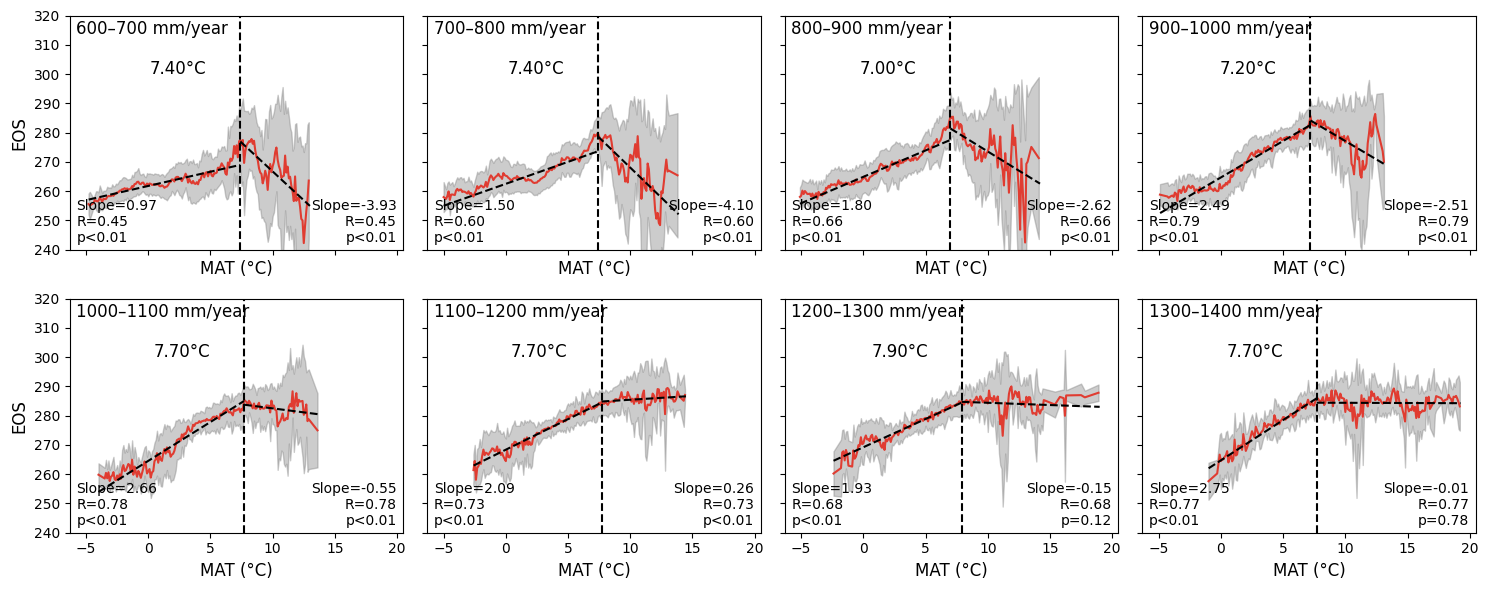

In [5]:
satellite = 'avhrr'
# satellite = 'modis'
# satellite = 'viirs'

veg_type = 0
df = read_satellite_data(veg_type, satellite)
df = df[
    (df['annual_t'] >= -20) & (df['annual_t'] <= 20) &
    (df['annual_p'] >= 0) & (df['annual_p'] <= 4)
]

fig = plot_mean_eos_by_temp_precip(df, temp_col='annual_t', precip_col='annual_p', eos_col='eos')
fig.savefig(f"../results/si_figures/si_fig1/{satellite}_prcp_threshold.png", dpi=300, bbox_inches='tight')